## Assignment for Coding 3 - Python course

### by Kristof F Rabay
---
#### Focus
Scrape flights data via the SkyScanner API for given date ranges in 2020 summer, all departing from Vienna

#### Summary of tasks needed
1. Scrape raw data via API call, turn JSONs into pandas.DFs, merge them to have a complete dataset to 'play with'
2. Basic exploration
3. Enrich with airport distance data via HTML scraping
4. Visualize results

#### Keep in mind
When enriching with weather data, will re-run scraping function (API restricts date selection, so will only be able to use that day's weather data

### Will append this notebook with homeworks coming up
#### <span style='background:lightgreen'> Done  </span>
Scrape via API, JSON-to-DF, merge DFs, concatenate all DFs from all links
Data in pd.DF, basic exploration, to_csv, read_csv, clean (dates, dtypes, etc...), group-bys, pivoting, matplots (and 1 seaborn), web scraping

#### <span style='background:skyblue'> Extra tasks  </span>
ML algos

### 1. Load needed libraries

In [2]:
import urllib.request as ur
import json
import re
import datetime
import missingno
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.error import HTTPError
from time import sleep
from IPython.display import display

### 2. Set date ranges to create links from

In [3]:
dates_from = pd.date_range(start='2020-06-20', end='2020-08-20')

In [7]:
# create the possible date ranges
dates_to_use = ["https://partners.api.skyscanner.net/apiservices/browsequotes/v1.0/HU-sky/HUF/en-US/VIE/Anywhere/" + dates_from.strftime("%Y-%m-%d") + "/" + (dates_from + i).strftime("%Y-%m-%d") + "?apiKey=INSERTAPI" for i in range(7,20 + 1)]

# unnest the nested list
links = [item for nested_list in dates_to_use for item in nested_list]

### 3. API call function

In [8]:
def get_df_from_url(url):

    content = ur.urlopen(url)
    jsons = json.loads(content.read())

    if jsons['Quotes'] == []:
        
        # there are date ranges that have no quotes for them --> would return an error, instead let's literally skip those urls
        pass

    else:

        quotes = json_normalize(jsons['Quotes'])
        places = json_normalize(jsons['Places'])
        carriers = json_normalize(jsons['Carriers'])

        date_columns = []
        for column in quotes.columns:
            if 'Date' in column:
                date_columns.append(column)

        quotes[date_columns] = quotes[date_columns].apply(lambda x: x.str.replace(re.compile('T\d{2}:\d{2}:\d{2}'),''))
        quotes[date_columns] = quotes[date_columns].astype('datetime64[ns]')

        object_columns = list(quotes.select_dtypes(include=['O']).columns)

        quotes[object_columns] = quotes[object_columns].astype('str').apply(lambda x: x.str.replace(re.compile(r'\W+'),''))
        quotes[object_columns] = quotes[object_columns].astype('int64')

        # Inboundleg.Destination = Outboundleg.Origin (both refer to the starting airport)
        # Outboundled.Destination = Inboundleg.Origin (both refer to the destination airport)
        # the 2 origins and 1 destination can be dropped

        quotes.drop(['InboundLeg.DestinationId', 'OutboundLeg.OriginId', 'InboundLeg.OriginId'], axis = 1, inplace = True)

        df = pd.merge(quotes,places[['CityName', 'CountryName', 'IataCode', 'PlaceId']], 
                     left_on = 'OutboundLeg.DestinationId', 
                     right_on ='PlaceId', 
                     how='left').merge(carriers, 
                                      how = 'left',
                                      left_on = 'OutboundLeg.CarrierIds',
                                      right_on = 'CarrierId').merge(carriers,
                                                                   how = 'left',
                                                                   left_on = 'InboundLeg.CarrierIds',
                                                                   right_on = 'CarrierId')
        return(df)

In [9]:
# list comprehension to run function on all links, then having pd.concat binding together the matching columns
sky_data = pd.concat([get_df_from_url(link) for link in links])

### 4. Wrangle and tidy the dataframe

In [11]:
data = sky_data.copy()

In [12]:
data.shape

(34764, 17)

In [13]:
data.head()

,Direct,InboundLeg.CarrierIds,InboundLeg.DepartureDate,MinPrice,OutboundLeg.CarrierIds,OutboundLeg.DepartureDate,OutboundLeg.DestinationId,QuoteDateTime,QuoteId,CityName,CountryName,IataCode,PlaceId,CarrierId_x,Name_x,CarrierId_y,Name_y
0,False,952,2020-06-27,197625.0,1618,2020-06-20,84501,2020-01-27,1,Taipei,Taiwan,TPE,84501,1618,Qatar Airways,952,Cathay Pacific
1,True,1555,2020-06-27,44476.0,1555,2020-06-20,81495,2020-01-21,2,Istanbul,Turkey,SAW,81495,1555,Pegasus Airlines,1555,Pegasus Airlines
2,False,1718,2020-06-27,186640.0,1718,2020-06-20,64012,2020-01-22,3,Kuala Lumpur,Malaysia,KUL,64012,1718,Saudia,1718,Saudia
3,True,1954,2020-06-27,180885.0,1954,2020-06-20,56951,2020-01-27,4,Hurghada,Egypt,HRG,56951,1954,Corendon Airlines Europe,1954,Corendon Airlines Europe
4,False,1755,2020-06-27,118824.0,1755,2020-06-20,56951,2020-01-27,5,Hurghada,Egypt,HRG,56951,1755,Turkish Airlines,1755,Turkish Airlines


In [14]:
# CarrierIDs are not needed, as their names are stored in separate columns
# Same goes for OutboundDestID: the destination airport is stored in a separate column
# QuoteID was SkyScanner's inner ID for that particular date's, destination's, origin's and carrier's pricing identification

data.drop(['InboundLeg.CarrierIds', 
           'OutboundLeg.CarrierIds', 
           'OutboundLeg.DestinationId', 
           'CarrierId_x', 
           'CarrierId_y', 
           'PlaceId', 
           'QuoteId'], axis = 1, inplace = True)

In [15]:
# Last two column names (names.x and names.y) make no sense for the readers
# The names are results of merging
# Let's rename them

data.rename(columns = {'Name_x': 'CarrierDeparting', 'Name_y': 'CarrierArriving'}, inplace=True)

In [16]:
# how does out df look now?

data.head()

,Direct,InboundLeg.DepartureDate,MinPrice,OutboundLeg.DepartureDate,QuoteDateTime,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving
0,False,2020-06-27,197625.0,2020-06-20,2020-01-27,Taipei,Taiwan,TPE,Qatar Airways,Cathay Pacific
1,True,2020-06-27,44476.0,2020-06-20,2020-01-21,Istanbul,Turkey,SAW,Pegasus Airlines,Pegasus Airlines
2,False,2020-06-27,186640.0,2020-06-20,2020-01-22,Kuala Lumpur,Malaysia,KUL,Saudia,Saudia
3,True,2020-06-27,180885.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Corendon Airlines Europe,Corendon Airlines Europe
4,False,2020-06-27,118824.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Turkish Airlines,Turkish Airlines


In [17]:
# Let's check the clean dataset's columns - names and types

data.dtypes

Direct                                 bool
InboundLeg.DepartureDate     datetime64[ns]
MinPrice                            float64
OutboundLeg.DepartureDate    datetime64[ns]
QuoteDateTime                datetime64[ns]
CityName                             object
CountryName                          object
IataCode                             object
CarrierDeparting                     object
CarrierArriving                      object
dtype: object

In [19]:
# don't want sci notation, let's set pandas options for formatting numbers
pd.options.display.float_format = '{:.2f}'.format

##### Let's see the distribution of numeric, and count stats of categorical features

In [20]:
# let's see our only numerical column's descriptive stats (will add two more numeric cols later via enrichment)
data.describe()

,MinPrice
count,34764.00
mean,92771.13
std,102681.30
min,10137.00
25%,28395.00
50%,52148.00
75%,117153.25
max,1689895.00


In [21]:
# let's explore categorical variables as well
data.describe(include = ['O'])

,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving
count,34764,34764,34764,34764,34764
unique,473,176,493,81,140
top,Tel Aviv,Turkey,TLV,Laudamotion,Laudamotion
freq,903,1133,903,13637,14050


In [22]:
# what does is mean that the top departing carrier is Laudamotion? most frequent? 
# let's check by grouping the data by carrierdeparting, and counting frequencies

data[['MinPrice', 'CarrierDeparting']] \
    .groupby('CarrierDeparting') \
    .agg(['mean', 'count']) \
    .sort_values(("MinPrice", "count"), ascending = False) \
    .head(10)

MinPrice       
                       mean  count
CarrierDeparting                  
Laudamotion        34379.76  13637
Wizz Air           45476.23   3579
LEVEL              80851.59   2982
eurowings          68250.59   2522
Ryanair            44644.94   1781
Austrian Airlines 194103.39   1701
Emirates          221532.54    902
Turkish Airlines  215700.29    613
Lufthansa         248734.27    470
Vueling Airlines  108285.30    463

##### Seems like the dataset has been tidied, now let's look at possible NAs, duplicates

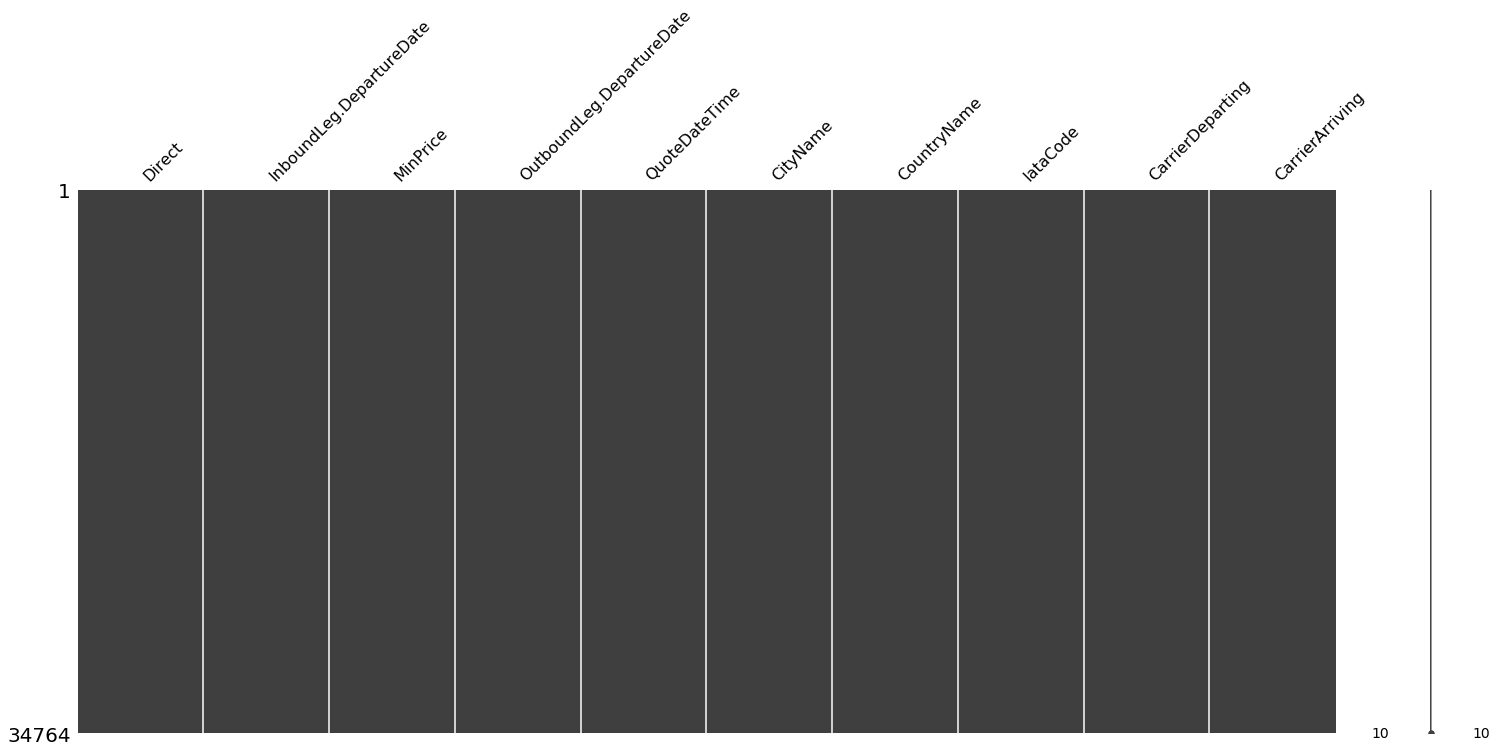

In [23]:
# missingno package offers a great visual to overview where (if any) the missing data is located

missingno.matrix(data)

In [25]:
# I can further make sure that none of the columns include NA values

data.isnull().any(axis=0)

Direct                       False
InboundLeg.DepartureDate     False
MinPrice                     False
OutboundLeg.DepartureDate    False
QuoteDateTime                False
CityName                     False
CountryName                  False
IataCode                     False
CarrierDeparting             False
CarrierArriving              False
dtype: bool

Seems like my data has no missing values. This can change, as weather data from API or airport distance data from HTML scrape might not find a particular airport. So will re-check NAs after enrichment

Let's check duplicates, if the same quote for the same date, locations and carriers somehow ended up in the dataset

In [26]:
# if there are any True values it would return True -- False indicates there are no duplications
# if there are any duplications, it would add them all together -- 0 indicated there are no duplications

data.duplicated().any(), data.duplicated().sum()

(False, 0)

One more thing before saving it all: some city names contain accents - let's encode them in 'ascii' so to have regular letters

In [27]:
# Male is seen as Malé

data['CityName'].unique()

array(['Taipei', 'Istanbul', 'Kuala Lumpur', 'Hurghada', 'Algiers',
       'Tel Aviv', 'Cuzco', 'Wellington', 'Reykjavik', 'Thunder Bay',
       'Cancun', 'Larnaca', 'New York', 'Melbourne', 'Marmagao', 'Malé',
       'Tashkent', 'Gibraltar', 'Kutaisi', 'Moscow', 'Warsaw',
       'Tunis Carthage', 'Helsinki', 'Madrid', 'Lisbon', 'Tallinn',
       'Bucharest', 'Stockholm', 'Copenhagen', 'Tirana', 'Mahe Island',
       'Casablanca', 'Tuzla', 'Bologna', 'Pristina', 'Chisinau',
       'Dubrovnik', 'Luqa', 'Thessaloniki', 'Shannon', 'Amsterdam',
       'Oslo', 'Brussels', 'Sofia', 'Zurich', 'Kyiv', 'Marseille',
       'Birmingham', 'Stuttgart', 'Antalya', 'Denpasar', 'Beirut',
       'Los Angeles', 'Shenyang', 'Almaty', 'Tbilisi', 'Colombo',
       'Nowy Dwor Mazowiecki', 'Lappeenranta', 'Porto', 'Cluj-Napoca',
       'Billund', 'Marrakech Menara', 'Nis', 'Sarajevo', 'Milan',
       'Athens', 'Dublin', 'Riga', 'Paris', 'Bristol', 'Ulaanbaatar',
       'Singapore', 'Manila', 'Bodrum', 'Jakar

In [28]:
city_country = ['CityName', 'CountryName']
data[city_country] = data[city_country].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

In [36]:
cityCount = data.groupby('CityName').size().sort_values(ascending=False).reset_index().rename(columns = {0 : 'count'})
cityCount[cityCount['CityName'] == 'Male']

,CityName,count
80,Male,95


I can now save my csv, it seems to have been tidied and cleaned, it can be later enriched and analyzed / visualized

In [37]:
data.to_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data.csv", 
            index = False, 
            encoding = 'utf-8')

Reading in the same csv, I can already pre-set rules, such as dtypes, as csvs don't store dtypes, so dates get read back as objects. For the date columns I can have pandas read them in as dates

In [3]:
data = pd.read_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data.csv",  
            parse_dates = ['InboundLeg.DepartureDate', 
                           'OutboundLeg.DepartureDate', 
                           'QuoteDateTime'])

### 5. Some exploration using matplotlib

In [4]:
data.columns

Index(['Direct', 'InboundLeg.DepartureDate', 'MinPrice',
       'OutboundLeg.DepartureDate', 'QuoteDateTime', 'CityName', 'CountryName',
       'IataCode', 'CarrierDeparting', 'CarrierArriving'],
      dtype='object')

Let's group by departure date, country, carrier and see the min price distribution

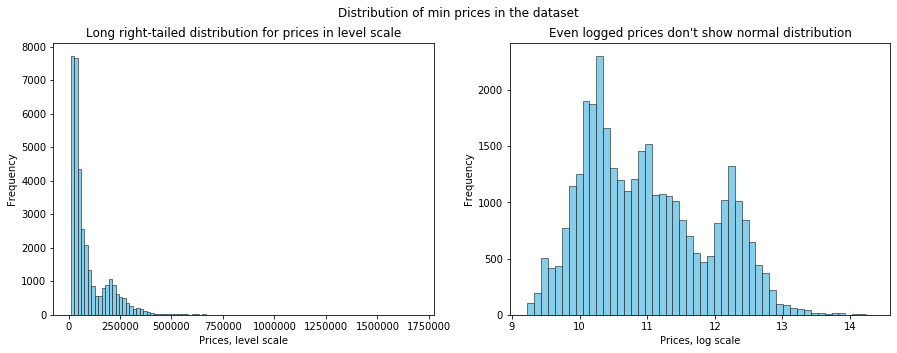

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Distribution of min prices in the dataset')

data['MinPrice'].plot(bins = 100,
                      kind='hist', 
                      color = 'skyblue',
                      lw = 0.5, 
                      ec = 'black',
                      title = "Long right-tailed distribution for prices in level scale",
                      ax=axes[0],
                      figsize = (15,5))

np.log(data['MinPrice']).plot(bins = 50,
                              kind='hist', 
                              color = 'skyblue',
                              lw = 0.5, 
                              ec = 'black',
                              title = "Even logged prices don't show normal distribution",                        
                              ax=axes[1])

axes[0].set_xlabel("Prices, level scale")
axes[1].set_xlabel("Prices, log scale")

plt.show()

In [5]:
# what are the most expensive flights in the data?
data.sort_values(by=['MinPrice'], ascending=False).head(5)

,Direct,InboundLeg.DepartureDate,MinPrice,OutboundLeg.DepartureDate,QuoteDateTime,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving
20313,False,2020-08-22,1689895.0,2020-08-08,2020-01-25,Male,Maldives,MLE,Singapore Airlines,Air India
11409,False,2020-07-25,1498302.0,2020-07-14,2020-01-24,Auckland,New Zealand,AKL,Austrian Airlines,Air China
6988,False,2020-08-05,1429885.0,2020-07-27,2020-01-26,Seoul,South Korea,ICN,Singapore Airlines,Singapore Airlines
7725,False,2020-08-23,1427562.0,2020-08-14,2020-01-21,Hong Kong,Hong Kong,HKG,Singapore Airlines,Singapore Airlines
21105,False,2020-07-08,1426605.0,2020-06-23,2020-01-22,Brasilia,Brazil,BSB,Ethiopian Airlines,Ethiopian Airlines


I will cut the prices off at 500,000 HUF and see the distribution then. 500,000 seems reasonable for me, as currently there's no place that would get me to pay half a million in Forints to sit on a 10 hour flight

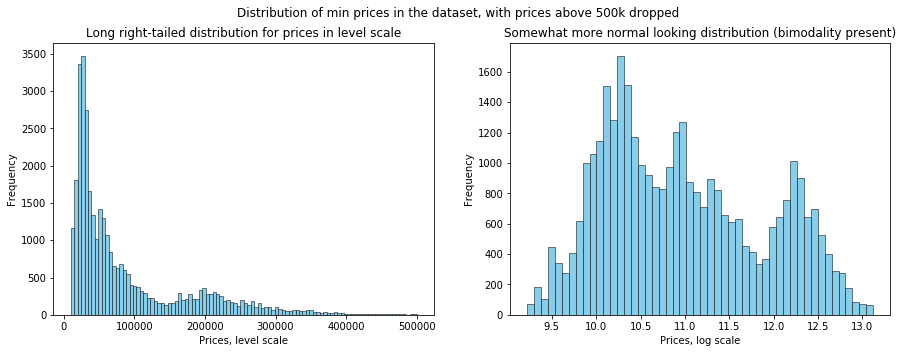

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Distribution of min prices in the dataset, with prices above 500k dropped')

data[data['MinPrice'] < 500000]['MinPrice'].plot(bins = 100,
                      kind='hist', 
                      color = 'skyblue',
                      lw = 0.5, 
                      ec = 'black',
                      title = "Long right-tailed distribution for prices in level scale",
                      ax=axes[0],
                      figsize = (15,5))

np.log(data[data['MinPrice'] < 500000]['MinPrice']).plot(bins = 50,
                              kind='hist', 
                              color = 'skyblue',
                              lw = 0.5, 
                              ec = 'black',
                              title = "Somewhat more normal looking distribution (bimodality present)",                        
                              ax=axes[1])

axes[0].set_xlabel("Prices, level scale")
axes[1].set_xlabel("Prices, log scale")

plt.show()

Before seeing some price-country patterns, let me get rid of countries that have less than 50 flights going there in our dataset.

In [7]:
NoFlightsToCountries = data.groupby('CountryName').size().sort_values(ascending = True).reset_index().rename(columns = {0 : 'count'})
NoFlightsToCountries.head(10)

,CountryName,count
0,Afghanistan,1
1,French Guiana,1
2,Grenada,1
3,Guyana,1
4,Equatorial Guinea,1
5,Malawi,1
6,Niger,1
7,Central African Republic,1
8,Palau,1
9,Papua New Guinea,1


In [8]:
atLeast50flights = data[data['CountryName'].isin(NoFlightsToCountries[NoFlightsToCountries['count'] > 50]['CountryName'])]

In [9]:
atLeast50flights_grouped = atLeast50flights.groupby('CountryName') \
                                            .agg({'MinPrice' : 'median', 'CarrierDeparting' : 'count'}) \
                                            .rename(columns = ({'CarrierDeparting' : 'count','MinPrice' : 'AvgMinPrice'})) \
                                            .sort_values(by=['count'], ascending=True)
atLeast50flights_grouped.head(10)

,AvgMinPrice,count
CountryName,,
Curacao,368978.0,59
Seychelles,258195.0,69
Dominican Republic,274860.5,72
Taiwan,237781.5,82
Australia,359657.0,83
Serbia,47323.0,84
Singapore,198771.0,85
Costa Rica,340289.0,87
Kenya,192232.0,87


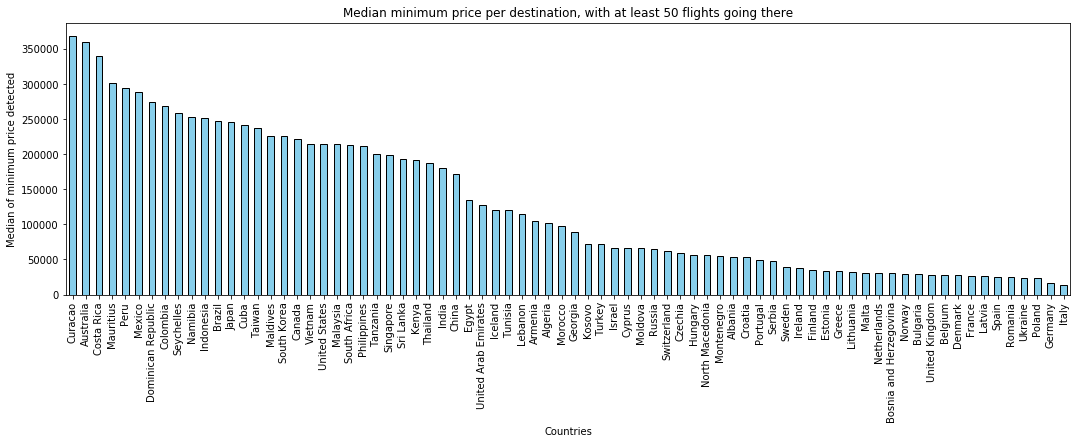

In [10]:
atLeast50flights_grouped['AvgMinPrice'] \
.sort_values(ascending = False) \
.plot(kind='bar',
     figsize = (18,5),
     title = 'Median minimum price per destination, with at least 50 flights going there',
     color = 'skyblue',
     ec = 'black')

plt.xlabel('Countries')
plt.ylabel("Median of minimum price detected")

plt.show()

In [11]:
print("There are", len(atLeast50flights.CarrierDeparting.unique()), "unique carriers")

There are 79 unique carriers


In [12]:
# let's filter for those that operate more than 50 flights

NoFlightsbyCarriers = atLeast50flights.groupby('CarrierDeparting') \
                                                .size() \
                                                .sort_values(ascending = True) \
                                                .reset_index() \
                                                .rename(columns = {0 : 'count'})
NoFlightsbyCarriers.head(5)

,CarrierDeparting,count
0,SriLankan Airlines,1
1,Belavia,1
2,China Eastern,1
3,LATAM Airlines Group,1
4,Saudia,1


In [13]:
atLeast50carriers = atLeast50flights[atLeast50flights['CarrierDeparting'].isin(NoFlightsbyCarriers[NoFlightsbyCarriers['count'] > 50]['CarrierDeparting'])]
atLeast50carriers.head()

,Direct,InboundLeg.DepartureDate,MinPrice,OutboundLeg.DepartureDate,QuoteDateTime,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving
0,False,2020-06-27,197625.0,2020-06-20,2020-01-27,Taipei,Taiwan,TPE,Qatar Airways,Cathay Pacific
1,True,2020-06-27,44476.0,2020-06-20,2020-01-21,Istanbul,Turkey,SAW,Pegasus Airlines,Pegasus Airlines
3,True,2020-06-27,180885.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Corendon Airlines Europe,Corendon Airlines Europe
4,False,2020-06-27,118824.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Turkish Airlines,Turkish Airlines
5,False,2020-06-27,74710.0,2020-06-20,2020-01-23,Algiers,Algeria,ALG,Vueling Airlines,Vueling Airlines


In [14]:
atLeast50carriers_grouped = atLeast50carriers.groupby('CarrierDeparting') \
                                                .agg({'MinPrice' : 'median', 'CarrierDeparting' : 'count'}) \
                                                .rename(columns = ({'CarrierDeparting' : 'count','MinPrice' : 'AvgMinPrice'})) \
                                                .sort_values(by=['count'], ascending=True)
atLeast50carriers_grouped.head(5)

,AvgMinPrice,count
CarrierDeparting,,
Corendon Airlines Europe,150631.0,57
Air China,231109.0,58
EgyptAir,163323.5,58
Aegean Airlines,96022.0,59
Ethiopian Airlines,273728.0,61


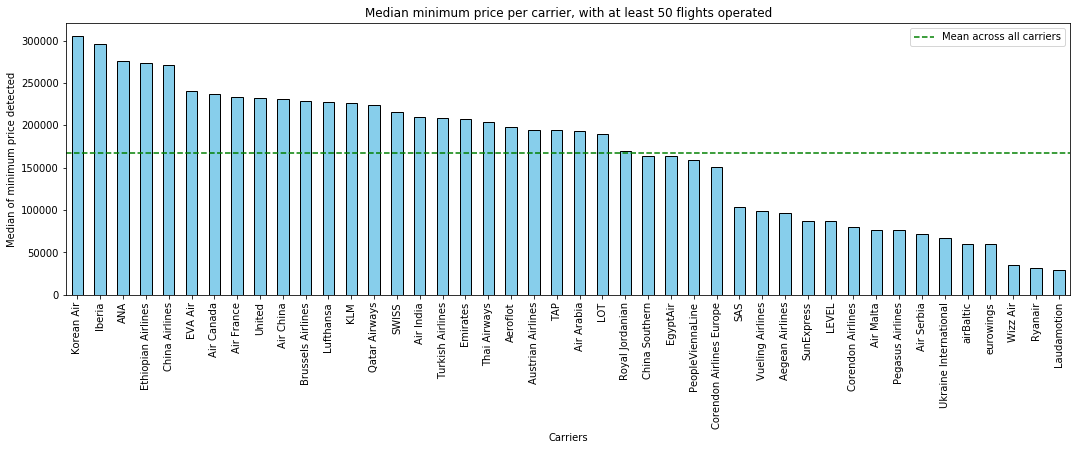

In [16]:
atLeast50carriers_grouped['AvgMinPrice'] \
.sort_values(ascending = False) \
.plot(kind='bar',
     figsize = (18,5),
     title = 'Median minimum price per carrier, with at least 50 flights operated',
     color = 'skyblue',
     ec = 'black')

plt.axhline(atLeast50carriers_grouped[atLeast50carriers_grouped.index != "Condor"]['AvgMinPrice'].mean(), color='g', linestyle='--')

plt.xlabel('Carriers')
plt.ylabel("Median of minimum price detected")

labels = ["Mean across all carriers"]
plt.legend(labels = labels)

plt.show()

Before finishing up with the visual exploration of my scraped data, let me draw up some boxplots to illustrate the ranges of prices across carriers

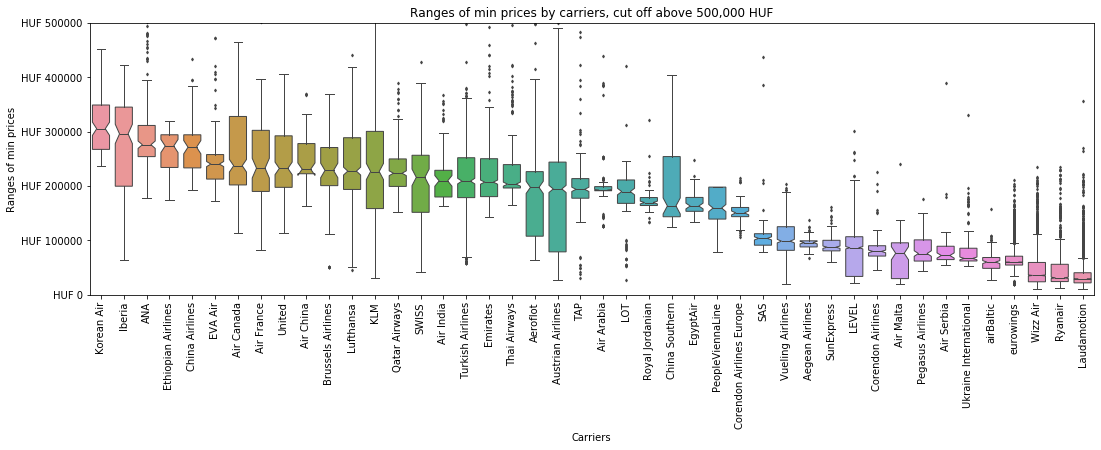

In [17]:
for_boxplots = pd.melt(atLeast50carriers, id_vars = ['CarrierDeparting'], value_vars = ['MinPrice'])

plt.figure(figsize=(18, 5))
bp = sns.boxplot(x = 'CarrierDeparting', 
                 y = 'value', 
                 data = for_boxplots, 
                 width = 0.75, 
                 fliersize = 2, 
                 linewidth = 1, 
                 notch = True, 
                 order = for_boxplots.groupby("CarrierDeparting")["value"].median().sort_values()[::-1].index)

bp.set(xlabel='Carriers', ylabel='Ranges of min prices')
bp.set_xticklabels(bp.get_xticklabels(), rotation = 90)
bp.set_title('Ranges of min prices by carriers, cut off above 500,000 HUF')
bp.set(ylim=(0, 500000))

ccy = ticker.FormatStrFormatter('HUF %1.0f')
bp.yaxis.set_major_formatter(ccy)

#sns.stripplot(x = 'CarrierDeparting', 
#              y = 'value', 
#              data = for_boxplots,
#              jitter = True, 
#              size = 1, 
#              edgecolor = 'gray')

plt.show()

In [21]:
print("Started off with all data, then filtered for at least 50 flights going to the given country, \nthen filtered for having all carriers operate at leasth 50 flights. \nHere's how the dimensions changed over these filterings\n")
print("Original:\t\t\t\t\t\t",data.shape)
print("Original + At least 50 flights to a country:\t\t",atLeast50flights.shape)
print("Previous + At least 50 flights operated by carrier:\t",atLeast50carriers.shape)

Started off with all data, then filtered for at least 50 flights going to the given country, 
then filtered for having all carriers operate at leasth 50 flights. 
Here's how the dimensions changed over these filterings

Original:						 (34764, 10)
Original + At least 50 flights to a country:		 (33662, 10)
Previous + At least 50 flights operated by carrier:	 (33220, 10)


I can save my lastly filtered data and work with that for further enhancements

In [22]:
atLeast50carriers.to_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data_filtered.csv", 
                            index = False, 
                            encoding = 'utf-8')

### 6. Enhancement of data thru web scraping

In [5]:
df = pd.read_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data_filtered.csv",  
                parse_dates = ['InboundLeg.DepartureDate', 
                               'OutboundLeg.DepartureDate', 
                               'QuoteDateTime'])

In [6]:
df.dtypes

Direct                                 bool
InboundLeg.DepartureDate     datetime64[ns]
MinPrice                            float64
OutboundLeg.DepartureDate    datetime64[ns]
QuoteDateTime                datetime64[ns]
CityName                             object
CountryName                          object
IataCode                             object
CarrierDeparting                     object
CarrierArriving                      object
dtype: object

##### Here come the API call for weather data and web-scraping for airport-to-airport distances, on which I can run a basic ML model

Let's extract my unique airport codes (IATA). I'll use them to get their distances from Vienna, using the lambda function. After that, I'll join the df containing the IATA-distance pairs to my dataset to create a new colum named `dist_to_Vienna` that will show those value.

In [48]:
to_scrape_to = pd.DataFrame(df['IataCode'].unique().tolist(), columns = ["IataCode"])
to_scrape_to.head()

,IataCode
0,TPE
1,SAW
2,HRG
3,ALG
4,TLV


I'll write a funtion that will scrape the distances by IATA code to Vienna airport:

In [41]:
def get_distance_from_vie(iata):
    
    # url used
    url = "https://www.prokerala.com/travel/airports/distance/from-vie/to-"+iata.lower()+"/"
    
    # set agent to avoid blocks
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36"
    
    # parse the HTML
    request = ur.Request(url,headers={'User-Agent': user_agent})
    
    # if URL is not found, avoid error
    try:
        html = ur.urlopen(request).read()

        soup = BeautifulSoup(html,'html.parser')

        # extract km number from HTML node containing needed information
        # need to keep the number in km
        to_keep = re.compile("\/([^:]+)km")

        # finding the needed match
        found_match = to_keep.findall(soup.find("h2").text)

        # result in list format, convert to string and clear whitespace
        match_to_string = " ".join(found_match)
        match_ws_removed = match_to_string.strip()

        # longer, hard to read version
        # match_ws_removed = " ".join(re.compile("\/([^:]+)km").findall(soup.find("h2").text)).strip()

        # convert to float (kms)
        distance_in_km = float(match_ws_removed)
        
    except HTTPError as err:
           if err.code == 404:
                distance_in_km = float('NaN')
           else:
                distance_in_km = "not_404_error_check_IATA"              
        
    return distance_in_km

In [42]:
# let's check it: distance of JFK to VIE in kms
get_distance_from_vie("JFK")

6806.94

In [43]:
# let's check if it can catch an error
get_distance_from_vie("NONEXISTENTAIRPORTCOE")

nan

Let's fill the second column of my to_scrape_to df with the distance values

In [49]:
to_scrape_to['dist_to_Vienna'] = to_scrape_to.apply(lambda x: get_distance_from_vie(x['IataCode']), axis = 1)
to_scrape_to.head()

,IataCode,dist_to_Vienna
0,TPE,8971.74
1,SAW,1287.53
2,HRG,2764.82
3,ALG,1671.99
4,TLV,2361.99


Let's check if there were any IATA codes that the scraper did not find matched for on the website

In [50]:
to_scrape_to[pd.isnull(to_scrape_to).any(axis=1)]

,IataCode,dist_to_Vienna
51,WMI,NaN
238,GSV,NaN
299,CDT,NaN
313,RGK,NaN
325,LOP,NaN


There are 5 airports of which we do not know the distances from Vienna. 

Before merging, I'll create a dictionary (as the homework asks me to do so):

keys: iatacodes

values: distances from Vienna

In [106]:
iata_dist_dict = dict(zip(to_scrape_to['IataCode'], to_scrape_to['dist_to_Vienna']))

In [107]:
iata_dist_dict

{'TPE': 8971.74,
 'SAW': 1287.53,
 'HRG': 2764.82,
 'ALG': 1671.99,
 'TLV': 2361.99,
 'CUZ': 11016.84,
 'YQT': 7142.86,
 'LCA': 2036.77,
 'JFK': 6806.94,
 'MEL': 15736.61,
 'GOI': 6333.27,
 'MLE': 7266.15,
 'KUT': 2126.06,
 'SVO': 1664.03,
 'DME': 1669.59,
 'WAW': 549.79,
 'TUN': 1354.74,
 'HEL': 1461.28,
 'MAD': 1806.27,
 'LIS': 2305.15,
 'TLL': 1367.55,
 'OTP': 829.4,
 'NYO': 1188.14,
 'CPH': 878.83,
 'TIA': 784.48,
 'SEZ': 6986.83,
 'CMN': 2594.18,
 'TZL': 438.15,
 'BLQ': 566.83,
 'PRN': 707.4,
 'KIV': 937.33,
 'DBV': 630.69,
 'MLA': 1373.41,
 'SKG': 984.99,
 'AMS': 959.16,
 'OSL': 1389.93,
 'CRL': 915.58,
 'SOF': 804.52,
 'ZRH': 602.08,
 'KBP': 1068.83,
 'MRS': 1020.65,
 'BHX': 1383.87,
 'STR': 547.87,
 'AYT': 1700.79,
 'DPS': 11371.95,
 'KEF': 2933.24,
 'BEY': 2235.53,
 'LAX': 9857.08,
 'SHE': 7736.47,
 'TBS': 2333.8,
 'CMB': 7453.95,
 'WMI': nan,
 'LPP': 1616.44,
 'OPO': 2125.36,
 'CLJ': 555.64,
 'BLL': 988.75,
 'RAK': 2766.89,
 'INI': 670.44,
 'SJJ': 495.22,
 'BGY': 587.43,
 'AT

Saving dict - method one: np

In [108]:
# saving the dictionary into a file
np.save('C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/iata_dist_dict.npy', iata_dist_dict) 

In [109]:
read_dict = np.load('C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/iata_dist_dict.npy', allow_pickle='TRUE').item()
read_dict

{'TPE': 8971.74,
 'SAW': 1287.53,
 'HRG': 2764.82,
 'ALG': 1671.99,
 'TLV': 2361.99,
 'CUZ': 11016.84,
 'YQT': 7142.86,
 'LCA': 2036.77,
 'JFK': 6806.94,
 'MEL': 15736.61,
 'GOI': 6333.27,
 'MLE': 7266.15,
 'KUT': 2126.06,
 'SVO': 1664.03,
 'DME': 1669.59,
 'WAW': 549.79,
 'TUN': 1354.74,
 'HEL': 1461.28,
 'MAD': 1806.27,
 'LIS': 2305.15,
 'TLL': 1367.55,
 'OTP': 829.4,
 'NYO': 1188.14,
 'CPH': 878.83,
 'TIA': 784.48,
 'SEZ': 6986.83,
 'CMN': 2594.18,
 'TZL': 438.15,
 'BLQ': 566.83,
 'PRN': 707.4,
 'KIV': 937.33,
 'DBV': 630.69,
 'MLA': 1373.41,
 'SKG': 984.99,
 'AMS': 959.16,
 'OSL': 1389.93,
 'CRL': 915.58,
 'SOF': 804.52,
 'ZRH': 602.08,
 'KBP': 1068.83,
 'MRS': 1020.65,
 'BHX': 1383.87,
 'STR': 547.87,
 'AYT': 1700.79,
 'DPS': 11371.95,
 'KEF': 2933.24,
 'BEY': 2235.53,
 'LAX': 9857.08,
 'SHE': 7736.47,
 'TBS': 2333.8,
 'CMB': 7453.95,
 'WMI': nan,
 'LPP': 1616.44,
 'OPO': 2125.36,
 'CLJ': 555.64,
 'BLL': 988.75,
 'RAK': 2766.89,
 'INI': 670.44,
 'SJJ': 495.22,
 'BGY': 587.43,
 'AT

Saving dict - method two: JSON

In [110]:
json.dump(iata_dist_dict, open("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/iata_dist_dict.json", 'w'))

In [111]:
read_dict = json.load(open("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/iata_dist_dict.json"))
read_dict

{'TPE': 8971.74,
 'SAW': 1287.53,
 'HRG': 2764.82,
 'ALG': 1671.99,
 'TLV': 2361.99,
 'CUZ': 11016.84,
 'YQT': 7142.86,
 'LCA': 2036.77,
 'JFK': 6806.94,
 'MEL': 15736.61,
 'GOI': 6333.27,
 'MLE': 7266.15,
 'KUT': 2126.06,
 'SVO': 1664.03,
 'DME': 1669.59,
 'WAW': 549.79,
 'TUN': 1354.74,
 'HEL': 1461.28,
 'MAD': 1806.27,
 'LIS': 2305.15,
 'TLL': 1367.55,
 'OTP': 829.4,
 'NYO': 1188.14,
 'CPH': 878.83,
 'TIA': 784.48,
 'SEZ': 6986.83,
 'CMN': 2594.18,
 'TZL': 438.15,
 'BLQ': 566.83,
 'PRN': 707.4,
 'KIV': 937.33,
 'DBV': 630.69,
 'MLA': 1373.41,
 'SKG': 984.99,
 'AMS': 959.16,
 'OSL': 1389.93,
 'CRL': 915.58,
 'SOF': 804.52,
 'ZRH': 602.08,
 'KBP': 1068.83,
 'MRS': 1020.65,
 'BHX': 1383.87,
 'STR': 547.87,
 'AYT': 1700.79,
 'DPS': 11371.95,
 'KEF': 2933.24,
 'BEY': 2235.53,
 'LAX': 9857.08,
 'SHE': 7736.47,
 'TBS': 2333.8,
 'CMB': 7453.95,
 'WMI': nan,
 'LPP': 1616.44,
 'OPO': 2125.36,
 'CLJ': 555.64,
 'BLL': 988.75,
 'RAK': 2766.89,
 'INI': 670.44,
 'SJJ': 495.22,
 'BGY': 587.43,
 'AT

I'll join this small df to my dataset, and drop those destinations of which we coulnd't scrape how far away they are from Vienna

In [52]:
df = pd.merge(df, 
              to_scrape_to, 
              left_on = 'IataCode', 
              right_on ='IataCode', 
              how='left')

df.head()

,Direct,InboundLeg.DepartureDate,MinPrice,OutboundLeg.DepartureDate,QuoteDateTime,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving,dist_to_Vienna
0,False,2020-06-27,197625.0,2020-06-20,2020-01-27,Taipei,Taiwan,TPE,Qatar Airways,Cathay Pacific,8971.74
1,True,2020-06-27,44476.0,2020-06-20,2020-01-21,Istanbul,Turkey,SAW,Pegasus Airlines,Pegasus Airlines,1287.53
2,True,2020-06-27,180885.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Corendon Airlines Europe,Corendon Airlines Europe,2764.82
3,False,2020-06-27,118824.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Turkish Airlines,Turkish Airlines,2764.82
4,False,2020-06-27,74710.0,2020-06-20,2020-01-23,Algiers,Algeria,ALG,Vueling Airlines,Vueling Airlines,1671.99


In [60]:
# dropping flights to airports I didn't get distances to
df = df[df['dist_to_Vienna'].notna()]

The distance column is new to my dataset, so let's explore it a little bit

In [62]:
df["dist_to_Vienna"].describe()

count    32805.000000
mean      2594.828912
std       2928.365790
min        210.280000
25%        878.830000
50%       1373.410000
75%       2361.990000
max      16216.630000
Name: dist_to_Vienna, dtype: float64

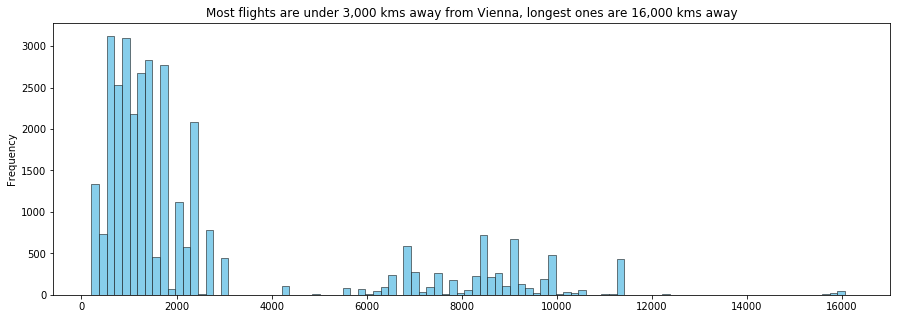

In [68]:
df['dist_to_Vienna'].plot(bins = 100,
                          kind='hist', 
                          color = 'skyblue',
                          lw = 0.5, 
                          ec = 'black',
                          title = "Most flights are under 3,000 kms away from Vienna, longest ones are 16,000 kms away",
                          figsize = (15,5))

plt.show()

In [89]:
print("Flights more than 15,000 kms away go to:", ", ".join(df[df['dist_to_Vienna'] > 15000]['CountryName'].unique().tolist()))

Flights more than 15,000 kms away go to: Australia


In [91]:
print("Flights between 10,000 and 15,000 kms away go to:", ", ".join(df[(df['dist_to_Vienna'] > 10000) & (df['dist_to_Vienna'] < 15000)]['CountryName'].unique().tolist()))

Flights between 10,000 and 15,000 kms away go to: Peru, Indonesia, Brazil, Philippines, Mexico, Colombia, Malaysia, United States, Costa Rica, Australia


In [92]:
df.dtypes

Direct                                 bool
InboundLeg.DepartureDate     datetime64[ns]
MinPrice                            float64
OutboundLeg.DepartureDate    datetime64[ns]
QuoteDateTime                datetime64[ns]
CityName                             object
CountryName                          object
IataCode                             object
CarrierDeparting                     object
CarrierArriving                      object
dist_to_Vienna                      float64
dtype: object

In [93]:
df.to_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data_filtered.csv", 
                            index = False, 
                            encoding = 'utf-8')

### 7. TBD

In [3]:
df = pd.read_csv("C://Users/Krisz/Desktop/ceu/materials/Coding3/Homework/sky_data_filtered.csv",  
                parse_dates = ['InboundLeg.DepartureDate', 
                               'OutboundLeg.DepartureDate', 
                               'QuoteDateTime'])

In [4]:
df.dtypes

Direct                                 bool
InboundLeg.DepartureDate     datetime64[ns]
MinPrice                            float64
OutboundLeg.DepartureDate    datetime64[ns]
QuoteDateTime                datetime64[ns]
CityName                             object
CountryName                          object
IataCode                             object
CarrierDeparting                     object
CarrierArriving                      object
dist_to_Vienna                      float64
dtype: object

## Below are a couple of ML algos I've tried, not part of assignment

#### Methodology:

X:

1. Time spend in destination
2. Time between quote and departure date
3. Month of stay
4. Distance from origin
5. Direct or not
6. Categoricals

y:

Price of flight

Algo:

- Dummy
- LinReg
- LASSO
- RF
- GradB
- AdaB

#### Best model: GBM (test score: 96.3% r2, 1.55% rmse ratio)

Additional possible performance bettering ideas: scaling / taking log of distance; interactions between carrier and country

In [200]:
display(perf)
display(perf_test)

,Model,RMSE on train,R2 on train,RMSE rate on train
4,GBM,0.125157,0.980002,0.011431
3,RF,0.172404,0.962055,0.015747
2,LASSO,0.241934,0.925276,0.022097
1,LinReg,0.245307,0.925563,0.022405
5,AdaBoost,0.366421,0.828594,0.033467
0,Dummy,0.885049,NaN,0.080836


,Model,RMSE on test,R2 on test,RMSE rate on test
0,GBM,0.170203,0.963067,0.015558


#### Best perfoming model's (gradient boosting machine) predictions vs truth chart

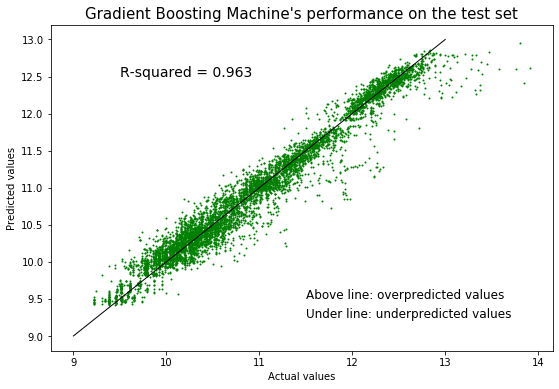

In [193]:
pred_by_gbm_on_test = grid_search_gbm.best_estimator_.predict(X_test)

r2_test = r2_score(y_test, pred_test)

pred_vs_act = pd.DataFrame(y_test)
pred_vs_act.rename(columns = {'min_price_log': 'actual'}, inplace=True)
pred_vs_act['predicted'] = pred_by_rf_on_test

pred_vs_act.plot(kind = 'scatter', 
                 x = ['actual'], y = ['predicted'], 
                 figsize = (9,6), 
                 c = "green", 
                 s = 1)

plt.text(9.5, 12.5, 'R-squared = %0.3f' % r2_test, fontsize = 14)

plt.xlabel('Actual values')
plt.ylabel("Predicted values")
plt.title("Gradient Boosting Machine's performance on the test set", fontdict = {'fontsize' : 15})

plt.plot([9, 13], [9, 13], color = 'black', linewidth = 1)

plt.text(11.5, 9.25, 'Under line: underpredicted values', fontsize = 12)
plt.text(11.5, 9.5, 'Above line: overpredicted values', fontsize = 12)

plt.show()

##### Feature Engineering

In [17]:
data = df.copy()
data.head()

,Direct,InboundLeg.DepartureDate,MinPrice,OutboundLeg.DepartureDate,QuoteDateTime,CityName,CountryName,IataCode,CarrierDeparting,CarrierArriving,dist_to_Vienna
0,False,2020-06-27,197625.0,2020-06-20,2020-01-27,Taipei,Taiwan,TPE,Qatar Airways,Cathay Pacific,8971.74
1,True,2020-06-27,44476.0,2020-06-20,2020-01-21,Istanbul,Turkey,SAW,Pegasus Airlines,Pegasus Airlines,1287.53
2,True,2020-06-27,180885.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Corendon Airlines Europe,Corendon Airlines Europe,2764.82
3,False,2020-06-27,118824.0,2020-06-20,2020-01-27,Hurghada,Egypt,HRG,Turkish Airlines,Turkish Airlines,2764.82
4,False,2020-06-27,74710.0,2020-06-20,2020-01-23,Algiers,Algeria,ALG,Vueling Airlines,Vueling Airlines,1671.99


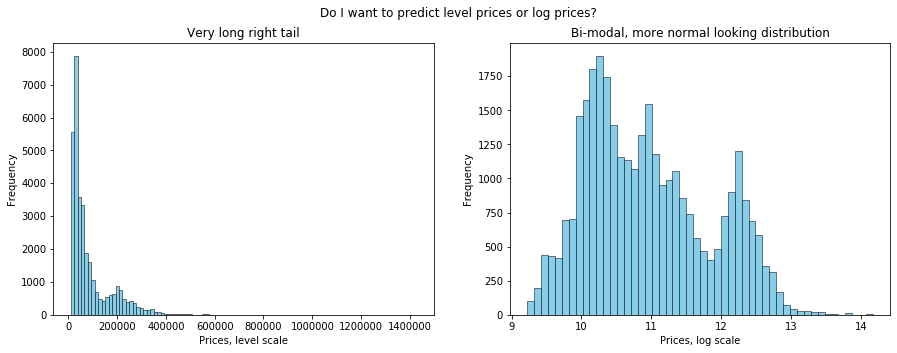

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Do I want to predict level prices or log prices?')

data['MinPrice'].plot(bins = 100,
                      kind='hist', 
                      color = 'skyblue',
                      lw = 0.5, 
                      ec = 'black',
                      title = "Very long right tail",
                      ax=axes[0],
                      figsize = (15,5))

np.log(data['MinPrice']).plot(bins = 50,
                              kind='hist', 
                              color = 'skyblue',
                              lw = 0.5, 
                              ec = 'black',
                              title = "Bi-modal, more normal looking distribution",                        
                              ax=axes[1])

axes[0].set_xlabel("Prices, level scale")
axes[1].set_xlabel("Prices, log scale")

plt.show()

In [136]:
data['min_price_log'] = np.log(data['MinPrice'])

KeyError: 'MinPrice'

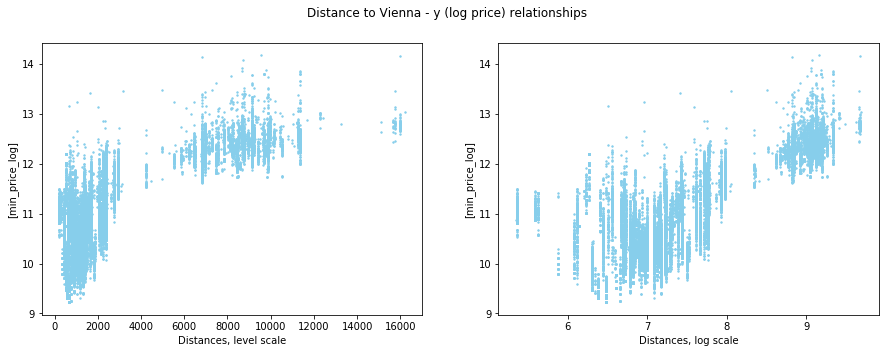

In [170]:
data['dist_to_Vienna_log'] = np.log(data['dist_to_Vienna'])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Distance to Vienna - y (log price) relationships')

data.plot(kind = 'scatter', 
          x = ['dist_to_Vienna'], y = ['min_price_log'], 
          figsize = (15,5), 
          color = "skyblue", 
          ax = axes[0], s = 2)

data.plot(kind = 'scatter', 
          x = ['dist_to_Vienna_log'], y = ['min_price_log'], 
          figsize = (15,5), 
          color = "skyblue", 
          ax = axes[1], s = 2)

axes[0].set_xlabel("Distances, level scale")
axes[1].set_xlabel("Distances, log scale")

plt.show()

I'll keep distances in level scale, let's see how the models do with that

##### Feature creation

Time spent in destination

In [20]:
data['days_spent'] = data['InboundLeg.DepartureDate'] - data['OutboundLeg.DepartureDate']
data['days_spent'] = data['days_spent'].dt.days

Month of arrival, month of departure

In [21]:
data['month_leaving'] = data['OutboundLeg.DepartureDate'].dt.month_name()
data['month_coming_back'] = data['InboundLeg.DepartureDate'].dt.month_name()

Time between quote and departure

In [22]:
data['days_quote_dep'] = data['OutboundLeg.DepartureDate'] - data['QuoteDateTime']
data['days_quote_dep'] = data['days_quote_dep'].dt.days

In [23]:
data.drop(['InboundLeg.DepartureDate', 'OutboundLeg.DepartureDate', 'CityName', 'IataCode', 'QuoteDateTime', 'MinPrice'], axis=1, inplace=True)

In [24]:
data.rename(columns = {'CarrierDeparting': 'depcar', 
                       'CarrierArriving': 'arrcar',  
                       'Direct' : 'direct', 
                       'CountryName' : 'country'}, inplace=True)

Turn boolean into 1s and 0s

In [25]:
data["direct"] = data["direct"].map({False : 0, True : 1}) 

In [26]:
data.head()

,direct,country,depcar,arrcar,dist_to_Vienna,min_price_log,days_spent,month_leaving,month_coming_back,days_quote_dep
0,0,Taiwan,Qatar Airways,Cathay Pacific,8971.74,12.194127,7,June,June,145
1,1,Turkey,Pegasus Airlines,Pegasus Airlines,1287.53,10.702705,7,June,June,151
2,1,Egypt,Corendon Airlines Europe,Corendon Airlines Europe,2764.82,12.105617,7,June,June,145
3,0,Egypt,Turkish Airlines,Turkish Airlines,2764.82,11.685399,7,June,June,145
4,0,Algeria,Vueling Airlines,Vueling Airlines,1671.99,11.221369,7,June,June,149


One-hot encode categoricals

In [27]:
data_encoded = data.copy()

In [28]:
data_encoded = pd.get_dummies(data_encoded, columns=["country", "depcar", "arrcar", "month_leaving", "month_coming_back"], 
                              prefix=["country", "depcar", "arrcar", "month_leaving", "month_coming_back"],
                              drop_first = True)

In [29]:
data_encoded.head()

,direct,dist_to_Vienna,min_price_log,days_spent,days_quote_dep,country_Algeria,country_Armenia,country_Australia,country_Belgium,country_Bosnia and Herzegovina,...,arrcar_Xiamen Airlines,arrcar_airBaltic,arrcar_easyJet,arrcar_eurowings,arrcar_jetBlue,month_leaving_July,month_leaving_June,month_coming_back_July,month_coming_back_June,month_coming_back_September
0,0,8971.74,12.194127,7,145,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,1287.53,10.702705,7,151,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,2764.82,12.105617,7,145,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,2764.82,11.685399,7,145,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,1671.99,11.221369,7,149,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


##### Split to train-test

In [180]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV (will do grid search instead)
from sklearn.model_selection import GridSearchCV

#from sklearn.preprocessing import StandardScaler (should scale features but probably will not)

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [31]:
X = data_encoded.drop(columns="min_price_log")
y = data_encoded["min_price_log"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20202020)

##### Dummy model to compare other models to

In [34]:
dummy_mean = DummyRegressor(strategy = "mean")

dummy_mean.fit(X_train, y_train)

dummy_pred = dummy_mean.predict(X_train)

dummy_mse = mean_squared_error(y_train, dummy_pred)
dummy_rmse = np.sqrt(dummy_mse)
dummy_rmse_ratio = dummy_rmse / np.mean(y_train)

print("Dummy model RMSE on the train dataset is: {}".format(dummy_rmse))
print("Dummy model RMSE ratio on the train dataset is: {}".format(dummy_rmse_ratio))

Dummy model RMSE on the train dataset is: 0.8850494228478999
Dummy model RMSE ratio on the train dataset is: 0.08083634726777203


##### Linear regression

In [122]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

r2_lr = r2_score(y_train, linreg.predict(X_train))

cv_scores = cross_val_score(linreg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

cvscores = np.sqrt(abs(cv_scores))

r2_score(y_train, linreg.predict(X_train))

print("LinReg 5-fold CV RMSE on train: {}".format(np.mean(cvscores)))

LinReg 5-fold CV RMSE on train: 0.2453070609086187


##### LASSO regression

In [51]:
param_grid = {'alpha': np.arange(0.00001, 0.0001, 0.00001)}

lasso = Lasso()

grid_search_lasso = GridSearchCV(estimator = lasso, 
                                 param_grid = param_grid, 
                                 cv = 5, 
                                 n_jobs = -1, 
                                 verbose = 0)

grid_search_lasso.fit(X_train, y_train)

C:\Users\Krisz\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.5174760431596, tolerance: 2.055725274830396
  positive)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05,
       9.e-05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [52]:
grid_search_lasso.best_params_

{'alpha': 1e-05}

In [123]:
lasso_pred = grid_search_lasso.best_estimator_.predict(X_train)
lasso_MSE = mean_squared_error(y_train, lasso_pred)
lasso_RMSE = np.sqrt(lasso_MSE)

r2_lasso = r2_score(y_train, lasso_pred)

print("LASSO RMSE on the train dataset is: {}".format(lasso_RMSE))

LASSO RMSE on the train dataset is: 0.2419342948697689


##### Random Forest

In [58]:
param_grid = {
    'max_depth': [100],
    'max_features': [40],
    'min_samples_leaf': [5],
    'min_samples_split': [15],
    'n_estimators': [500]
}

rf = RandomForestRegressor(random_state = 20202020)

grid_search_rf = GridSearchCV(estimator = rf, 
                              param_grid = param_grid, 
                              cv = 5, 
                              n_jobs = -1, 
                              verbose = 0)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [100, 110], 'max_fea

In [59]:
grid_search_rf.best_params_

{'max_depth': 100,
 'max_features': 40,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 500}

In [124]:
rf_pred = grid_search_rf.best_estimator_.predict(X_train)
RF_MSE = mean_squared_error(y_train, rf_pred)
RF_RMSE = np.sqrt(RF_MSE)

r2_rf = r2_score(y_train, rf_pred)

print("Random forest RMSE on the train dataset is: {}".format(RF_RMSE))

Random forest RMSE on the train dataset is: 0.1724035510294243


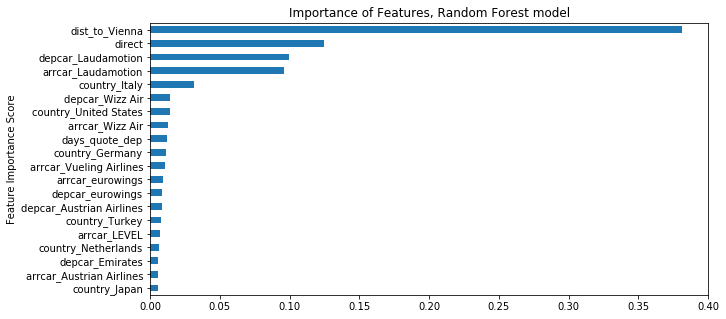

In [61]:
pd.Series(grid_search_rf.best_estimator_.feature_importances_, list(X_train)). \
sort_values(ascending=True). \
tail(20). \
plot(kind='barh', figsize = (10,5), title='Importance of Features, Random Forest model')

plt.ylabel('Feature Importance Score')
plt.show()

##### Gradient Boosting Machine

In [185]:
param_grid = {'learning_rate':[0.1], 
           'n_estimators': [500], 
           'max_features' : [80],
           'max_depth' : [8],
           'min_samples_split' : [2]}

gbm = GradientBoostingRegressor(random_state = 20202020)

grid_search_gbm = GridSearchCV(estimator = gbm,
                               param_grid = param_grid, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1,
                               cv=5, 
                               verbose = 0)

grid_search_gbm.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [186]:
grid_search_gbm.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 80,
 'min_samples_split': 2,
 'n_estimators': 500}

In [187]:
gbm_pred = grid_search_gbm.best_estimator_.predict(X_train)
GBM_MSE = mean_squared_error(y_train, gbm_pred)
GBM_RMSE = np.sqrt(GBM_MSE)

r2_gbm = r2_score(y_train, gbm_pred)

print("Gradient boosting machine RMSE on the train dataset is: {}".format(GBM_RMSE))

Gradient boosting machine RMSE on the train dataset is: 0.12515740521569538


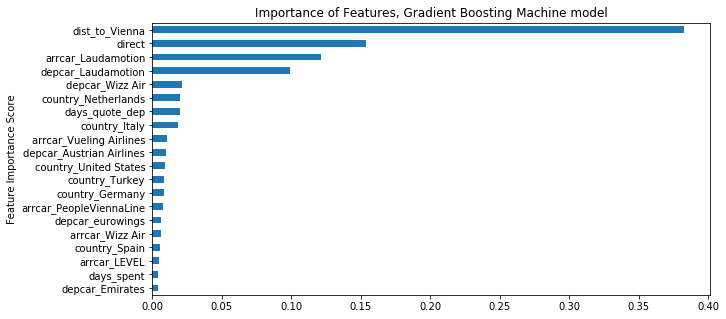

In [188]:
pd.Series(grid_search_gbm.best_estimator_.feature_importances_, list(X_train)). \
sort_values(ascending=True). \
tail(20). \
plot(kind='barh', figsize = (10,5), title='Importance of Features, Gradient Boosting Machine model')

plt.ylabel('Feature Importance Score')
plt.show()

##### AdaBoost Regressor

In [194]:
param_grid = {'learning_rate':[0.01], 
              'n_estimators': [500], 
              'loss' : ['linear']} # won't try exponential, linear was chosen over square

ada = AdaBoostRegressor(random_state = 20202020)

adab_search_gbm = GridSearchCV(estimator = ada,
                               param_grid = param_grid, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1,
                               cv=5, 
                               verbose = 0)

adab_search_gbm.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=20202020),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'loss': ['linear'],
                         'n_estimators': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [195]:
adab_search_gbm.best_params_

{'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 500}

In [196]:
ada_pred = adab_search_gbm.best_estimator_.predict(X_train)
ADA_MSE = mean_squared_error(y_train, ada_pred)
ADA_RMSE = np.sqrt(ADA_MSE)

r2_ada = r2_score(y_train, ada_pred)

print("Adaptive boosting machine RMSE on the train dataset is: {}".format(ADA_RMSE))

Adaptive boosting machine RMSE on the train dataset is: 0.3664213407046523


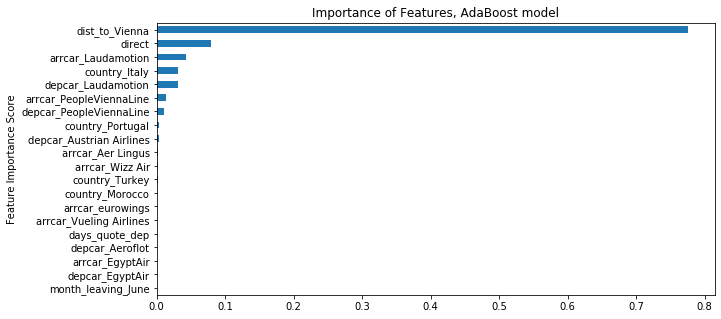

In [197]:
pd.Series(adab_search_gbm.best_estimator_.feature_importances_, list(X_train)). \
sort_values(ascending=True). \
tail(20). \
plot(kind='barh', figsize = (10,5), title='Importance of Features, AdaBoost model')

plt.ylabel('Feature Importance Score')
plt.show()

#### Performances, validation on test set

In [198]:
perf = [['Dummy',dummy_rmse, float('NaN')], ['LinReg',np.mean(cvscores), r2_lr], ['LASSO',lasso_RMSE, r2_lasso], ['RF', RF_RMSE, r2_rf], ['GBM', GBM_RMSE, r2_gbm], ['AdaBoost', ADA_RMSE, r2_ada]]
perf = pd.DataFrame(perf, columns = ['Model', 'RMSE on train', 'R2 on train'])
perf = perf.sort_values(by=['RMSE on train'], ascending = True)
perf['RMSE rate on train'] = perf['RMSE on train'].apply(lambda x: x / np.mean(y_train))
perf

,Model,RMSE on train,R2 on train,RMSE rate on train
4,GBM,0.125157,0.980002,0.011431
3,RF,0.172404,0.962055,0.015747
2,LASSO,0.241934,0.925276,0.022097
1,LinReg,0.245307,0.925563,0.022405
5,AdaBoost,0.366421,0.828594,0.033467
0,Dummy,0.885049,NaN,0.080836


The best performing model is the Gradient Boosting Machine - off by 1.1% on average, R2 is 98%

Let's validate the best performing model on the test set:

In [199]:
pred_test = grid_search_gbm.best_estimator_.predict(X_test)
test_r2 = r2_score(y_test, pred_test)
test_MSE = mean_squared_error(y_test, pred_test)
test_RMSE = np.sqrt(test_MSE)
test_RMSE_ratio = test_RMSE / np.mean(y_test)

perf_test = [['GBM', test_RMSE, test_r2, test_RMSE_ratio]]
perf_test = pd.DataFrame(perf_test, columns = ['Model', 'RMSE on test', 'R2 on test', 'RMSE rate on test'])
perf_test

,Model,RMSE on test,R2 on test,RMSE rate on test
0,GBM,0.170203,0.963067,0.015558


GBM's performance: 1.1% off on train, 1.5% off on test, 98% r2 on train, 96.3% r2 on test --> GOOD JOB by GBM (minimal, marginal overfit)